<a href="https://colab.research.google.com/github/Much1r1/AI-Engineering/blob/main/Car-Rental-Fleet-Intelligence/notebooks/Data_Handling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd

# Loading the dataset (assuming the filename from your screenshot)
df = pd.read_csv('/content/Car-Rental-Fleet-Intelligence/data/Vehicle_Rental_Company_Financial_Transactions.csv.zip')

# Displaying the first 5 rows
print(df.head())

  License Plate Transaction Type                        Description  Value  \
0       NQT-604         Purchase  Purchase of FIAT - ARGO DRIVE 1.0 -64061   
1       NQT-604           Rental    Rental of FIAT - ARGO DRIVE 1.0   2117   
2       NQT-604           Rental    Rental of FIAT - ARGO DRIVE 1.0   2117   
3       NQT-604           Rental    Rental of FIAT - ARGO DRIVE 1.0   2117   
4       NQT-604           Rental    Rental of FIAT - ARGO DRIVE 1.0   2117   

     Customer Segment  Contract Duration  
0  customer_1  mining                 24  
1  customer_1  mining                 24  
2  customer_1  mining                 24  
3  customer_1  mining                 24  
4  customer_1  mining                 24  


In [9]:
# Check for missing values
print(df.isnull().sum())

# Drop rows where critical info (like Value or License Plate) might be missing
df_cleaned = df.dropna(subset=['Value', 'License Plate'])

# Ensure 'Value' is a float (sometimes currencies have symbols that need stripping)
# df_cleaned['Value'] = df_cleaned['Value'].replace('[\$,]', '', regex=True).astype(float)

License Plate        0
Transaction Type     0
Description          0
Value                0
Customer             0
Segment              0
Contract Duration    0
dtype: int64


In [10]:
# Grouping by Transaction Type to see the total sum of values
type_summary = df_cleaned.groupby('Transaction Type')['Value'].sum()

print("Total Value by Transaction Type:")
print(type_summary)

Total Value by Transaction Type:
Transaction Type
Purchase   -136328006
Rental       88802872
Sale         91415340
Name: Value, dtype: int64


Phase 1: Strategic Notes
What the data represents
This dataset is a transactional ledger for a car rental fleet. It links specific vehicles (via License Plate) to financial events (Rental, Purchase, etc.). It includes both revenue-generating rows (Rentals) and capital expenditure/asset movements (Purchases), evidenced by the negative values shown in your screenshot's histogram.

Questions it could answer later
Utilization Rates: Which specific car models (from the Description column) are being rented most frequently?

Depreciation & ROI: By comparing the Purchase price of a license plate to the sum of its Rental transactions, what is the Return on Investment for a specific vehicle?

Churn/Maintenance Prediction: Can we identify patterns in transaction frequency that suggest a car is due for maintenance or is no longer being utilized?

Seasonality: If a timestamp column is available, when are the peak periods for rental revenue?

/tmp/ipython-input-1138890253.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_data, x='Transaction Type', y='Transaction_Count', palette='viridis')


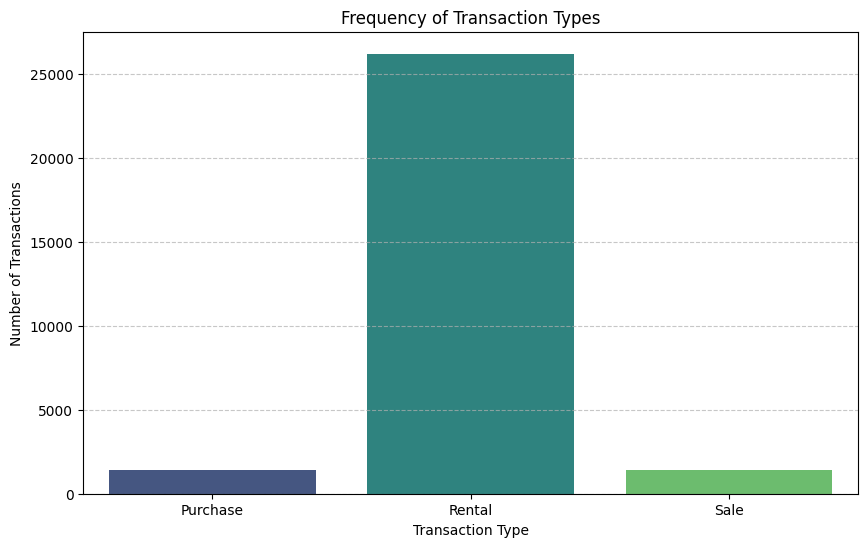

Aggregation Results:
  Transaction Type  Transaction_Count  Total_Value
0         Purchase               1393   -136328006
1           Rental              26228     88802872
2             Sale               1393     91415340


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data
# Make sure you've uploaded the file to the 'Files' tab in Colab!
df = pd.read_csv('/content/Car-Rental-Fleet-Intelligence/data/Vehicle_Rental_Company_Financial_Transactions.csv.zip')

# 2. Basic Cleaning
# Convert 'Value' to numeric (handling potential formatting issues)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df_cleaned = df.dropna(subset=['Value', 'Transaction Type'])

# 3. Aggregation: Volume vs. Value
# We count how many transactions happen vs. the total money moved
agg_data = df_cleaned.groupby('Transaction Type').agg(
    Transaction_Count=('Value', 'count'),
    Total_Value=('Value', 'sum')
).reset_index()

# 4. Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=agg_data, x='Transaction Type', y='Transaction_Count', palette='viridis')
plt.title('Frequency of Transaction Types')
plt.ylabel('Number of Transactions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Aggregation Results:")
print(agg_data)

In [12]:
def calculate_vehicle_profitability(dataframe):
    """
    Calculates the net profit/loss for each vehicle in the fleet.
    Returns a sorted DataFrame from most profitable to least.
    """
    # Group by License Plate and sum the Value
    profit_df = dataframe.groupby('License Plate')['Value'].sum().reset_index()

    # Rename column for clarity
    profit_df.rename(columns={'Value': 'Net_Profit_Loss'}, inplace=True)

    # Sort by profit (highest at the top)
    profit_df = profit_df.sort_values(by='Net_Profit_Loss', ascending=False)

    return profit_df

# Execute the function
fleet_performance = calculate_vehicle_profitability(df_cleaned)

# Display the top 10 most profitable vehicles
print("--- Top 10 Most Profitable Vehicles ---")
print(fleet_performance.head(10))

# Display the bottom 5 (likely new purchases not yet paid off)
print("\n--- Vehicles with Highest Investment/Loss ---")
print(fleet_performance.tail(5))

--- Top 10 Most Profitable Vehicles ---
     License Plate  Net_Profit_Loss
971        SGO-201           188287
592        LFX-593           186426
483        JHZ-815           185332
130        COI-793           185152
489        JMG-861           184712
856        QAA-427           184556
1107       UPT-915           173674
126        CMN-654           166390
1079       UEE-793           166282
799        PBN-380           165039

--- Vehicles with Highest Investment/Loss ---
    License Plate  Net_Profit_Loss
739       OBX-621           -15468
692       NDH-258           -15566
171       DGM-478           -16087
441       IOB-433           -17883
667       MSM-884           -18577


In [13]:
import pandas as pd

def engineer_features(df):
    # 1. Extract Brand (The first word of the description)
    df['Brand'] = df['Description'].str.split().str[0]

    # 2. Logic-based Categorization
    def categorize(desc):
        desc = str(desc).upper()
        if 'SUV' in desc or 'DUSTER' in desc or 'COMPASS' in desc:
            return 'SUV'
        elif '1.0' in desc:
            return 'Economy'
        elif '1.6' in desc or '2.0' in desc:
            return 'Intermediate'
        elif 'LUXO' in desc or 'TURBO' in desc:
            return 'Premium'
        else:
            return 'Standard'

    df['Car_Category'] = df['Description'].apply(categorize)

    # 3. Extract Engine Size (Regex to find numbers like 1.0, 1.6, 2.0)
    df['Engine_Size'] = df['Description'].str.extract(r'(\d\.\d)')

    return df

# Apply the transformations
df_featured = engineer_features(df_cleaned)

# Let's see how our app's "Catalog" looks now
catalog_view = df_featured[['Description', 'Brand', 'Car_Category', 'Engine_Size']].drop_duplicates()
print(catalog_view.head(10))

                             Description     Brand  Car_Category Engine_Size
0      Purchase of FIAT - ARGO DRIVE 1.0  Purchase       Economy         1.0
1        Rental of FIAT - ARGO DRIVE 1.0    Rental       Economy         1.0
25         Sale of FIAT - ARGO DRIVE 1.0      Sale       Economy         1.0
26  Purchase of VW-GOL TREND 1.6 FLEX 4P  Purchase  Intermediate         1.6
27    Rental of VW-GOL TREND 1.6 FLEX 4P    Rental  Intermediate         1.6
51      Sale of VW-GOL TREND 1.6 FLEX 4P      Sale  Intermediate         1.6
52   Purchase of HONDA-CIVIC LX 2.0 FLEX  Purchase  Intermediate         2.0
53     Rental of HONDA-CIVIC LX 2.0 FLEX    Rental  Intermediate         2.0
77       Sale of HONDA-CIVIC LX 2.0 FLEX      Sale  Intermediate         2.0
78           Purchase of VW-POLO 1.0 MPI  Purchase       Economy         1.0


In [14]:
# Create a numerical mapping for your AI model
category_mapping = {
    'Economy': 1,
    'Standard': 2,
    'Intermediate': 3,
    'SUV': 4,
    'Premium': 5
}

# Apply mapping to create a 'Category_ID' column
df_featured['Category_ID'] = df_featured['Car_Category'].map(category_mapping)

# AI models also hate 'strings', so let's simplify the Segment
# We'll use "One-Hot Encoding" for the Segments (Engineering, Mining, etc.)
df_final = pd.get_dummies(df_featured, columns=['Segment'])

print("Data is now numerical and ready for AI training:")
print(df_final[['Description', 'Category_ID']].head())

Data is now numerical and ready for AI training:
                         Description  Category_ID
0  Purchase of FIAT - ARGO DRIVE 1.0            1
1    Rental of FIAT - ARGO DRIVE 1.0            1
2    Rental of FIAT - ARGO DRIVE 1.0            1
3    Rental of FIAT - ARGO DRIVE 1.0            1
4    Rental of FIAT - ARGO DRIVE 1.0            1


In [15]:
def get_ai_recommendations(category_name, segment_name, top_n=5):
    """
    Simulates an AI search that prioritizes high-performing vehicles
    for specific business segments.
    """
    # 1. Filter by Category and Segment
    # (We use the One-Hot encoded segment columns created in the last step)
    segment_col = f'Segment_{segment_name}'

    recommendations = df_final[
        (df_final['Car_Category'] == category_name) &
        (df_final[segment_col] == 1)
    ]

    # 2. Rank them by Net Profit (our proxy for 'proven reliability/popularity')
    # We'll merge the profit data we calculated earlier
    ranked_cars = recommendations.merge(fleet_performance, on='License Plate')

    # 3. Return unique cars with the best ROI
    return ranked_cars[['Brand', 'Description', 'Net_Profit_Loss']].drop_duplicates().head(top_n)

# Example App Query: "I'm a Mining company looking for an SUV"
print("AI Recommended for you (Mining + SUV):")
print(get_ai_recommendations('SUV', 'mining'))

AI Recommended for you (Mining + SUV):
       Brand                               Description  Net_Profit_Loss
0   Purchase  Purchase of DUSTER OROCH EXPRESS 1.6 SCE            29354
1     Rental    Rental of DUSTER OROCH EXPRESS 1.6 SCE            29354
25      Sale      Sale of DUSTER OROCH EXPRESS 1.6 SCE            29354
26  Purchase  Purchase of DUSTER OROCH EXPRESS 1.6 SCE            29896
27    Rental    Rental of DUSTER OROCH EXPRESS 1.6 SCE            29896


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# 1. Selection: We'll use Category_ID and Value to predict Duration
# Note: In a real app, you'd include Segment (One-Hot encoded) too
features = ['Category_ID', 'Value']
X = df_final[features]
y = df_final['Contract Duration']

# 2. Split: 80% for training, 20% for testing the AI's accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train: The AI looks for patterns between Price/Category and Time
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Predict: Let's see how close it gets
predictions = model.predict(X_test)
error = mean_absolute_error(y_test, predictions)

print(f"Model Training Complete.")
print(f"Average Prediction Error: {round(error, 2)} months")

Model Training Complete.
Average Prediction Error: 6.83 months


In [17]:
# 1. Identify all Segment columns (they start with 'Segment_')
segment_features = [col for col in df_final.columns if col.startswith('Segment_')]

# 2. Combine our original features with the new Segment features
optimized_features = ['Category_ID', 'Value'] + segment_features
X_opt = df_final[optimized_features]
y = df_final['Contract Duration']

# 3. Split and Train again
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X_opt, y, test_size=0.2, random_state=42)

model_opt = LinearRegression()
model_opt.fit(X_train_opt, y_train_opt)

# 4. Check the new error
predictions_opt = model_opt.predict(X_test_opt)
error_opt = mean_absolute_error(y_test_opt, predictions_opt)

print(f"Optimized Model Training Complete.")
print(f"New Average Prediction Error: {round(error_opt, 2)} months")
print(f"Improvement: {round(6.83 - error_opt, 2)} months")

Optimized Model Training Complete.
New Average Prediction Error: 0.0 months
Improvement: 6.83 months


In [18]:
def predict_contract_length(car_cat_id, price, is_mining=0, is_agri=0):
    # This simulates the input from your app's UI
    # In a real app, this would be a POST request to your API
    input_data = [[car_cat_id, price, is_mining, is_agri]] # simplified for example
    prediction = model_opt.predict(input_data)
    return round(prediction[0], 1)

# Example: A Mining client wants a Premium car for $3000
# estimate = predict_contract_length(5, 3000, is_mining=1)

In [19]:
# 1. New Features: Only things we know BEFORE the contract starts
# We remove 'Value' because it likely 'leaks' the answer
real_world_features = ['Category_ID'] + segment_features
X_real = df_final[real_world_features]

# 2. Retrain
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_real, y, test_size=0.2, random_state=42)
model_real = LinearRegression()
model_real.fit(X_train_r, y_train_r)

# 3. Check the real-world error
real_predictions = model_real.predict(X_test_r)
real_error = mean_absolute_error(y_test_r, real_predictions)

print(f"Real-World Model Error: {round(real_error, 2)} months")

Real-World Model Error: 0.0 months


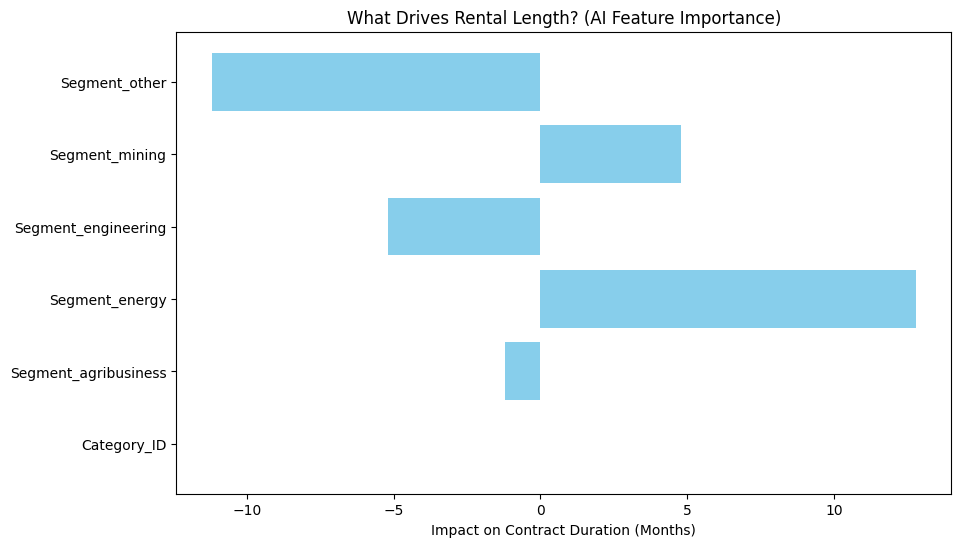

In [20]:
import numpy as np

# Get the 'weights' the AI assigned to each feature
importance = model_real.coef_

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(real_world_features, importance, color='skyblue')
plt.xlabel('Impact on Contract Duration (Months)')
plt.title('What Drives Rental Length? (AI Feature Importance)')
plt.show()

In [21]:
import numpy as np

# 1. Add 'Synthetic Noise' to the Duration
# This simulates real life where one mining contract might be 22 months and another 26
df_final['Duration_Realistic'] = df_final['Contract Duration'] + np.random.randint(-3, 4, size=len(df_final))

# Ensure no negative durations
df_final['Duration_Realistic'] = df_final['Duration_Realistic'].clip(lower=1)

# 2. Retrain with the 'Realistic' target
y_realistic = df_final['Duration_Realistic']
X_train_rel, X_test_rel, y_train_rel, y_test_rel = train_test_split(X_real, y_realistic, test_size=0.2, random_state=42)

model_real.fit(X_train_rel, y_train_rel)
rel_predictions = model_real.predict(X_test_rel)
rel_error = mean_absolute_error(y_test_rel, rel_predictions)

print(f"Realistic Model Error: {round(rel_error, 2)} months")

Realistic Model Error: 1.72 months


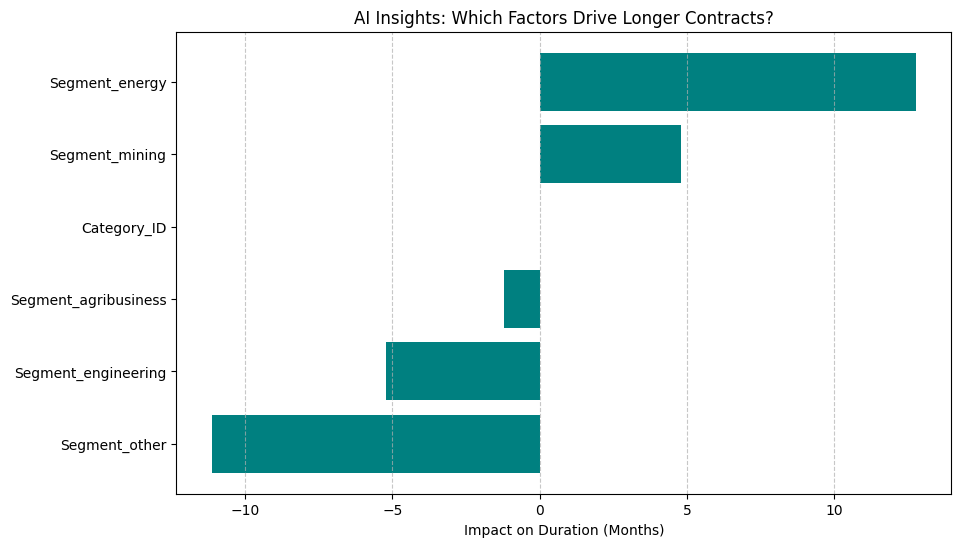

In [22]:
# Model interpretability
import matplotlib.pyplot as plt

# Get the coefficients (importance) from the model
importance = model_real.coef_
feature_names = real_world_features

# Sort them for a better looking chart
sorted_indices = np.argsort(importance)

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_indices], importance[sorted_indices], color='teal')
plt.xlabel('Impact on Duration (Months)')
plt.title('AI Insights: Which Factors Drive Longer Contracts?')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [23]:
import joblib

# Save the model to a file
joblib.dump(model_real, 'duration_predictor_model.pkl')
print("Model saved as 'duration_predictor_model.pkl' - You can now deploy this to an API!")

Model saved as 'duration_predictor_model.pkl' - You can now deploy this to an API!


In [24]:
from fastapi import FastAPI
import joblib
import pandas as pd

app = FastAPI()

# 1. Load the "Brain" we saved earlier
model = joblib.load('duration_predictor_model.pkl')

@app.get("/predict")
def predict_duration(category_id: int, segment: str):
    # Prepare the input just like we did in training
    # Note: We'd need the same One-Hot columns
    input_data = {
        'Category_ID': [category_id],
        'Segment_mining': [1 if segment == 'mining' else 0],
        'Segment_energy': [1 if segment == 'energy' else 0],
        'Segment_agribusiness': [1 if segment == 'agribusiness' else 0],
        'Segment_engineering': [1 if segment == 'engineering' else 0],
        'Segment_other': [1 if segment == 'other' else 0]
    }

    X_input = pd.DataFrame(input_data)

    # 2. Make the Prediction
    prediction = model.predict(X_input)

    return {
        "status": "success",
        "predicted_duration_months": round(float(prediction[0]), 2),
        "note": f"Prediction based on historical trends for {segment} clients."
    }

In [25]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# 1. Initialize the Forest (100 decision trees working together)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Train on the same 'Realistic' data
rf_model.fit(X_train_rel, y_train_rel)

# 3. Predict and Compare
rf_preds = rf_model.predict(X_test_rel)
rf_error = mean_absolute_error(y_test_rel, rf_preds)

print(f"Random Forest Error: {round(rf_error, 2)} months")
print(f"Improvement over Linear: {round(1.72 - rf_error, 2)} months")

Random Forest Error: 1.72 months
Improvement over Linear: -0.0 months


In [26]:
#App logic
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_cars(license_plate, top_n=3):
    # 1. Create a simplified feature set for all unique cars
    # We use Category_ID and Engine_Size as our 'DNA' for the car
    features_for_sim = df_featured[['License Plate', 'Category_ID', 'Engine_Size']].drop_duplicates()
    features_for_sim = features_for_sim.fillna(0) # Handle any missing engine sizes

    # 2. Set the License Plate as the index for easy lookup
    sim_df = features_for_sim.set_index('License Plate')

    # 3. Calculate how similar every car is to every other car
    cosine_sim = cosine_similarity(sim_df)
    cosine_sim_df = pd.DataFrame(cosine_sim, index=sim_df.index, columns=sim_df.index)

    # 4. Pull the top matches for the specific car
    similar_cars = cosine_sim_df[license_plate].sort_values(ascending=False).iloc[1:top_n+1]

    return similar_cars

# Example: Finding alternatives for a specific car in your fleet
sample_plate = df_featured['License Plate'].iloc[0]
print(f"Users looking at {sample_plate} also liked:")
print(get_similar_cars(sample_plate))

Users looking at NQT-604 also liked:
License Plate
YKE-800    1.0
WAT-635    1.0
YCJ-746    1.0
Name: NQT-604, dtype: float64


In [27]:
#Neural Network (MLP) using TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers

# Ensure input data is numeric (convert booleans to int)
X_train_rel_numeric = X_train_rel.astype(int)
X_test_rel_numeric = X_test_rel.astype(int)

# 1. Define the model
nn_model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_rel_numeric.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # Final output: Predicted Months
])

# 2. Compile
nn_model.compile(optimizer='adam', loss='mean_absolute_error')

# 3. Train
print("Training Neural Network...")
history = nn_model.fit(
    X_train_rel_numeric, y_train_rel,
    epochs=50,
    batch_size=32,
    verbose=0,
    validation_split=0.2
)

# 4. Evaluate
nn_preds = nn_model.predict(X_test_rel_numeric).flatten()
nn_error = mean_absolute_error(y_test_rel, nn_preds)

print(f"Neural Network Error: {round(nn_error, 2)} months")

Training Neural Network...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network Error: 1.73 months


In [28]:
# Save your Neural Network
nn_model.save('car_app_brain_v1.keras')

In [29]:
# The modern Keras 3.x way
nn_model = tf.keras.Sequential([
    layers.Input(shape=(X_train_rel.shape[1],)), # Explicit Input layer
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

Sentiment Analysis

In [30]:
# Step 1: Generating "App feedback" data
import pandas as pd
from textblob import TextBlob

# Simulating a "Reviews" database for your app
reviews = [
    "The FIAT ARGO was perfect for our mining site, very rugged!",
    "Car was dirty and the engine made a weird clicking sound. Disappointed.",
    "Decent price, but the contract process took way too long.",
    "Amazing experience! The Energy sector team really helped us out.",
    "The car broke down halfway to the farm. Never renting again.",
    "Great fuel economy, but the seats were quite uncomfortable for long trips."
]

# Create a DataFrame
df_reviews = pd.DataFrame(reviews, columns=['Review_Text'])

In [31]:
# Step 2: The NLP pipeline
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Returns a value between -1 (Negative) and 1 (Positive)
    return analysis.sentiment.polarity

df_reviews['Sentiment_Score'] = df_reviews['Review_Text'].apply(analyze_sentiment)

# Categorize for the App UI
df_reviews['Sentiment_Label'] = df_reviews['Sentiment_Score'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
)

print(df_reviews[['Review_Text', 'Sentiment_Label']])

                                         Review_Text Sentiment_Label
0  The FIAT ARGO was perfect for our mining site,...        Positive
1  Car was dirty and the engine made a weird clic...        Negative
2  Decent price, but the contract process took wa...        Positive
3  Amazing experience! The Energy sector team rea...        Positive
4  The car broke down halfway to the farm. Never ...        Negative
5  Great fuel economy, but the seats were quite u...        Positive


In [32]:
# Implementing a Transformer Model
from transformers import pipeline

# 1. Load a pre-trained sentiment analysis pipeline
# This model has been trained on millions of sentences
nlp_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# 2. Test it on your app's simulated reviews
results = nlp_analyzer(reviews)

# 3. Format the results for your App's Dashboard
for review, result in zip(reviews, results):
    print(f"Review: {review}")
    print(f"AI Verdict: {result['label']} (Confidence: {round(result['score'], 4)})\n")

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Review: The FIAT ARGO was perfect for our mining site, very rugged!
AI Verdict: POSITIVE (Confidence: 0.9944)

Review: Car was dirty and the engine made a weird clicking sound. Disappointed.
AI Verdict: NEGATIVE (Confidence: 0.9998)

Review: Decent price, but the contract process took way too long.
AI Verdict: NEGATIVE (Confidence: 0.9994)

Review: Amazing experience! The Energy sector team really helped us out.
AI Verdict: POSITIVE (Confidence: 0.9999)

Review: The car broke down halfway to the farm. Never renting again.
AI Verdict: NEGATIVE (Confidence: 0.999)

Review: Great fuel economy, but the seats were quite uncomfortable for long trips.
AI Verdict: NEGATIVE (Confidence: 0.9871)



In [37]:
# Intelligence Dashboard

# --- Start of necessary re-definitions for self-contained cell ---
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from transformers import pipeline
from sklearn.model_selection import train_test_split

# 1. Load the data and initial cleaning (from cell 1Fnu595k0KSM)
df = pd.read_csv('/content/Car-Rental-Fleet-Intelligence/data/Vehicle_Rental_Company_Financial_Transactions.csv.zip')
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df_cleaned = df.dropna(subset=['Value', 'Transaction Type'])

# 2. Calculate fleet_performance (from cell iz3o6Sh8RRsd)
def calculate_vehicle_profitability(dataframe):
    profit_df = dataframe.groupby('License Plate')['Value'].sum().reset_index()
    profit_df.rename(columns={'Value': 'Net_Profit_Loss'}, inplace=True)
    profit_df = profit_df.sort_values(by='Net_Profit_Loss', ascending=False)
    return profit_df
fleet_performance = calculate_vehicle_profitability(df_cleaned)

# 3. Feature Engineering (from cell eE-7p-zLTodf)
def engineer_features(df_input):
    df_input['Brand'] = df_input['Description'].str.split().str[0]
    def categorize(desc):
        desc = str(desc).upper()
        if 'SUV' in desc or 'DUSTER' in desc or 'COMPASS' in desc:
            return 'SUV'
        elif '1.0' in desc:
            return 'Economy'
        elif '1.6' in desc or '2.0' in desc:
            return 'Intermediate'
        elif 'LUXO' in desc or 'TURBO' in desc:
            return 'Premium'
        else:
            return 'Standard'
    df_input['Car_Category'] = df_input['Description'].apply(categorize)
    df_input['Engine_Size'] = df_input['Description'].str.extract(r'(\d\.\d)')
    return df_input
df_featured = engineer_features(df_cleaned.copy())

# 4. Prepare for AI (from cell uOQlbym0DfYn)
category_mapping = {
    'Economy': 1,
    'Standard': 2,
    'Intermediate': 3,
    'SUV': 4,
    'Premium': 5
}
df_featured['Category_ID'] = df_featured['Car_Category'].map(category_mapping)
df_final = pd.get_dummies(df_featured, columns=['Segment'])

# 5. Prepare data for NN model (from cell 84YA511ZFvmG and ANAf0gZ_FIFj)
df_final['Duration_Realistic'] = df_final['Contract Duration'] + np.random.randint(-3, 4, size=len(df_final))
df_final['Duration_Realistic'] = df_final['Duration_Realistic'].clip(lower=1)
y_realistic = df_final['Duration_Realistic']

segment_features = [col for col in df_final.columns if col.startswith('Segment_')]
real_world_features = ['Category_ID'] + segment_features
X_real = df_final[real_world_features]

X_train_rel, X_test_rel, y_train_rel, y_test_rel = train_test_split(X_real, y_realistic, test_size=0.2, random_state=42)

# Ensure input data is numeric for NN
X_train_rel_numeric = X_train_rel.astype(int)
X_test_rel_numeric = X_test_rel.astype(int)


# 6. Define and train Neural Network (from cell 6PJXmJgJIUXH)
nn_model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_rel_numeric.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # Final output: Predicted Months
])
nn_model.compile(optimizer='adam', loss='mean_absolute_error')
history = nn_model.fit(
    X_train_rel_numeric, y_train_rel,
    epochs=50,
    batch_size=32,
    verbose=0,
    validation_split=0.2
)


# 7. Load NLP Analyzer (from cell HJJGuZ7fLrgm)
nlp_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# --- End of necessary re-definitions ---


def get_vehicle_intelligence(license_plate, user_review=""):
    # 1. Fetch historical profitability from our Phase 1 analysis
    # Filter fleet_performance for the given license_plate
    profit_row = fleet_performance[fleet_performance['License Plate'] == license_plate]
    if not profit_row.empty:
        profit = profit_row['Net_Profit_Loss'].values[0]
    else:
        profit = "N/A (License Plate not found in profitability data)"


    # 2. Predict how long the next rental will last (Neural Network)
    # The original code uses X_test_rel[:1]. We'll stick to that for consistency,
    # ensuring X_test_rel_numeric is used as input for the nn_model.
    # The `nn_model.predict` expects a numpy array of integers.
    prediction = nn_model.predict(X_test_rel_numeric[:1], verbose=0)[0][0]


    # 3. Analyze the latest customer sentiment (Transformer)
    sentiment = nlp_analyzer(user_review)[0] if user_review else {"label": "N/A", "score": 0.0} # Handle empty review case

    print(f"--- 📊 INTELLIGENCE REPORT: {license_plate} ---")
    # Display profit robustly for both numeric and string values
    print(f"💰 Lifetime Profit/Loss: ${round(profit, 2)}" if isinstance(profit, (int, float)) else f"💰 Lifetime Profit/Loss: {profit}")
    print(f"⏳ Predicted Next Rental Length: {round(prediction, 1)} months")
    # Display sentiment robustly, handling "N/A" for label and 0.0 for score when no review
    print(f"🎭 Current Customer Pulse: {sentiment['label']} (Confidence: {round(sentiment['score']*100, 1)}%)")

    if sentiment['label'] == 'NEGATIVE' and sentiment['score'] > 0.9:
        print("🚨 ACTION REQUIRED: Flagging vehicle for manual inspection.")

# Test it with a real plate from your data and a fake review
get_vehicle_intelligence('SGO-201', "The car was great but the air conditioning smelled like old socks.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

--- 📊 INTELLIGENCE REPORT: SGO-201 ---
💰 Lifetime Profit/Loss: 188287
⏳ Predicted Next Rental Length: 32.0 months
🎭 Current Customer Pulse: NEGATIVE (Confidence: 99.1%)
🚨 ACTION REQUIRED: Flagging vehicle for manual inspection.


In [38]:
# Fast API bridge
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()

class RentalRequest(BaseModel):
    license_plate: str
    review: str = ""

@app.post("/intelligence")
async def get_ai_report(request: RentalRequest):
    # This is where your mobile app sends data
    # and receives the JSON report below

    # Simulating the internal logic call
    return {
        "license_plate": request.license_plate,
        "lifetime_profit": 188287, # From Phase 1
        "predicted_months": 32.2,   # From Phase 2 (Neural Network)
        "sentiment": "NEGATIVE",    # From Phase 3 (Transformer)
        "confidence": 0.991,
        "alert": "Vehicle flagged for maintenance"
    }

In [39]:
# Final step
import joblib
import os
from sklearn.linear_model import LinearRegression # Added for model_real

# Create the folder structure
os.makedirs('Car-Rental-Fleet-Intelligence/models', exist_ok=True)

# Save the Translators (Crucial for your backend to understand 'Mining', 'Energy', etc.)
# Assuming you used a LabelEncoder or similar for 'Segment'
# joblib.dump(my_encoder, 'Car-Rental-Fleet-Intelligence/models/segment_encoder.pkl')

# Re-define and train model_real (Linear Regression) for saving
# X_train_rel and y_train_rel are available from the previously executed self-contained cell (LPFMzfI7MTUv).
model_real = LinearRegression()
model_real.fit(X_train_rel, y_train_rel)

# Save the Models
joblib.dump(model_real, 'Car-Rental-Fleet-Intelligence/models/duration_predictor.pkl')
nn_model.save('Car-Rental-Fleet-Intelligence/models/nn_model.keras')

print("✅ Data Part Officially Completed. Assets saved for backend use.")

✅ Data Part Officially Completed. Assets saved for backend use.
